# Using Long Short Term Memory (LSTM) networks for stock price prediction

In this project, we are using tensorflow to predict 7-day returns on the S&P 500 index (^GSPC). 
You can download the data needed to run this notebook from yahoo finance at https://finance.yahoo.com/quote/%5EGSPC/history?p=^GSPC. 

In [815]:
import pandas as pd
import tensorflow as tf
import numpy as np
import time 
import datetime
import matplotlib.pyplot as plt
% matplotlib inline

## Normalization of input and output data
Input data to the network will be normalized using z-score normalization. The normalization will be run separately at every input sequence so as to account for numbers differing widely between years (they are much higher today than 30 years ago).

In [1038]:
def normalize_df(df):
    '''
    z-score normalization for a single time window
    '''
    return (df - df.mean(axis=0)) / df.std(axis = 0)

def normalize_return(v):
    '''
    Normalize returns to range [-1, 1]
    '''
    return v / max_abs_return

def restore_return(v):
    return v * max_abs_return

## Preparing the inputs
Data will be processed by feeding sequences of 60 days to the network. Per batch, 64 of these sequences will be processed. The newest data will be used for testing the model.

In [1068]:
gspc = pd.read_csv("gspc.csv") # get these from yahoo finance

gspc = gspc[-365*7:]


in_advance = 7
sequence_size = 60
batch_size = 64

n_layers = 3
n_cells = 32

returns = (gspc.iloc[in_advance:]["Adj Close"].values / gspc.iloc[:-in_advance]["Adj Close"] - 1).values
gspc = gspc[:-in_advance]


n_testbatches = 2
gspc_train = gspc.iloc[:-batch_size*n_testbatches-sequence_size]
y_train = returns[:-batch_size*n_testbatches-sequence_size]
gspc_test  = gspc.iloc[-batch_size*n_testbatches-sequence_size:]
y_test  = returns[-batch_size*n_testbatches-sequence_size:]


max_abs_return = np.max(np.abs(returns))

## Defining methods for accessing normalized training and testing batches

In [1069]:
def get_sequence(n=sequence_size):
    start = np.random.randint(0, len(gspc_train) - sequence_size - 1)
    x = gspc_train.iloc[start:start+n][['Open', 'High', 'Low', 'Adj Close', 'Volume']]
    y = y_train[start + n]
    return np.asarray(normalize_df(x).values), normalize_return(y)

def get_test_sequence(n=sequence_size, start=0):
    x = gspc_test.iloc[start:start+n][['Open', 'High', 'Low', 'Adj Close', 'Volume']]
    y = y_test[start + n]
    return np.asarray(normalize_df(x).values), normalize_return(y)
    

def get_batch(b=batch_size, n=sequence_size):
    return [np.asarray(get_sequence(n)) for _ in range(b)]

def get_test_batch(i=0, b=batch_size, n=sequence_size):
    return [np.asarray(get_test_sequence(n, b * i + bk)) for bk in range(b)]
    

## Creating the LSTM model
The input is being fed to the network in the form of batches holding 64 sequences of data for days following on each other directly. For each day, there exist 5 values (open, high, low, adj. close, volume). The LSTM needs the input to have a different form; the variable `Xs` thus is a list of dimensions sequence_size x batch_size x n_features. We take the last output of our LSTM and apply a matrix multiplication to get our predicted values.

In [1075]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(batch_size, sequence_size, 5), name="X")
Xs = [tf.squeeze(part) for part in tf.split(X, sequence_size, axis=1)]
Y = tf.placeholder(dtype=tf.float32, shape=batch_size, name="y")

cells = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_cells) for _ in range(n_layers)])
initial_state = cells.zero_state(tf.shape(X)[0], tf.float32)
outputs, state = tf.contrib.rnn.static_rnn(cells, Xs, initial_state=initial_state)
last_output = outputs[-1]

outmatrix = tf.Variable(tf.truncated_normal([n_cells, 1]), dtype=tf.float32)
outbias   = tf.Variable(tf.constant(0.001))


result = tf.squeeze(tf.matmul(last_output, outmatrix) + outbias)


#result = tf.squeeze(tf.layers.dense(last_output, units=1, activation=tf.nn.tanh))
loss = tf.reduce_mean(tf.losses.absolute_difference(result, Y))

## Creating an optimizer and applying gradient clipping

In [1076]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
gvs = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)

In [1077]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Training the model
Losses converge relatively fast.

In [1078]:
for i in range(10000):
    batch = get_batch()
    
    
    x = np.asarray([b[0] for b in batch])
    y = np.asarray([b[1] for b in batch])
    
    sess.run(train_op, feed_dict={X: x, Y: y})
    
    if i % 10 == 0:
        ls, res = sess.run([loss, result], feed_dict={X: x, Y: y})
        print(i, ls)
        

0 0.255499
10 0.140058
20 0.0917127
30 0.0778731
40 0.0838
50 0.0872837
60 0.0795073
70 0.0880756
80 0.125589
90 0.101911
100 0.0942539
110 0.0890166
120 0.107151
130 0.102824
140 0.102865
150 0.120988
160 0.0834461
170 0.0967107
180 0.0985768
190 0.109795
200 0.0961341
210 0.0724958


KeyboardInterrupt: 

## Comparing predictions and real data on the testing set

0.00736554846978
0.00672730014596


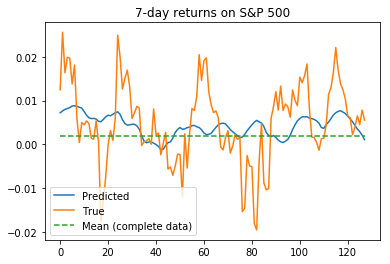

In [1080]:
testbatch = get_test_batch(0)
x = np.asarray([b[0] for b in testbatch])
y = np.asarray([b[1] for b in testbatch])

testbatch2 = get_test_batch(1)
x2 = np.asarray([b[0] for b in testbatch2])
y2 = np.asarray([b[1] for b in testbatch2])


ls, res = sess.run([loss, result], feed_dict={X: x, Y: y})
res2 =    sess.run(result, feed_dict={X: x2})

res = np.squeeze(np.append(res, res2))

restored = restore_return(res)
restored_true = np.append(restore_return(y), restore_return(y2))


plt.figure()
plt.title("7-day returns on S&P 500")
plt.plot(restored, label='Predicted')
plt.plot(restored_true, label='True')

mn = [np.mean(returns) for _ in range(len(restored))]
plt.plot(mn, label='Mean (complete data)', ls="--")
plt.legend()

print(np.mean(np.absolute(mn - restored_true)))
print(np.mean(np.absolute(restored - restored_true)))

## Conclusion
The prediction accuracy on the trained model is higher than the mean return baseline. However, the provided data seems not to be sufficient for reliably solving this task. Stock prediction is considered to be one of the most difficult time series prediction problems. Possible adjustments could include
* Providing the data of multiple securities
* Adding fundamental data--the model currently is completely relying on technical analysis of a single index
* Adding less obvious data sources like sentiment analysis etc.